In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append(os.getcwd())
import scanpy as sc
import pandas as pd
import anndata as ad

# from STdGCN.STdGCN import run_STdGCN
# import pandas as pd

In [2]:
os.chdir('/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/seqfish_SS_cortex/')

In [3]:
data_dir = '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/Allen_VISp'

## Annotation ##

In [3]:
sc_data = pd.read_csv("./mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_exon-matrix.csv")

In [4]:
sc_meta = pd.read_csv("./mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_samples-columns.csv")

In [37]:
gene = pd.read_csv("./mouse_VISp_gene_expression_matrices_2018-06-14/mouse_VISp_2018-06-14_genes-rows.csv")

In [26]:
sc_data.index = sc_data['Unnamed: 0']
del sc_data['Unnamed: 0']

In [7]:
scvi = pd.read_csv(os.path.join(data_dir,'Allen_data_scvi.csv'))
scvi.index = scvi['Unnamed: 0']
del scvi['Unnamed: 0']

In [27]:
print(sc_data.shape)
print(scvi.shape)
print(sc_meta.shape)

(45768, 15413)
(14249, 34617)
(15413, 50)


In [39]:
gene.index =gene.gene_entrez_id

In [44]:
gene =gene.loc[sc_data.index,:]

In [46]:
adata_rna = ad.AnnData(sc_data.transpose())
adata_rna.obs_names = pd.Index(sc_data.columns)
adata_rna.var_names = pd.Index(gene['gene_symbol'].to_list())

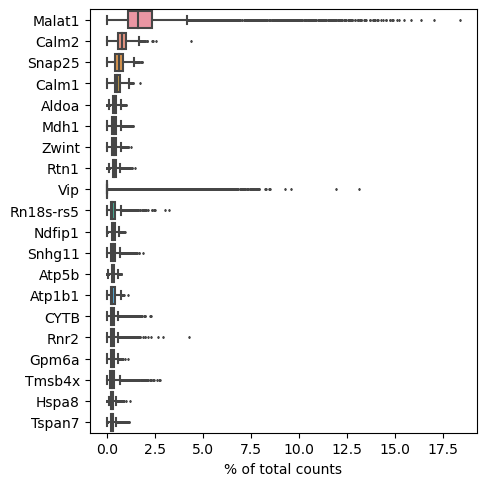

In [31]:
file_name = 'Allen_VISp'
sc.pl.highest_expr_genes(adata, n_top=20, save='_'+file_name+'_scRNA.svg')

In [51]:
mito_gene = pd.read_csv("/data/lyx/ref/mouse_mitogene.csv")['Symbol'].to_list()

In [52]:
sc.pp.filter_genes(adata_rna, min_cells=3)
adata_rna.var['mt'] = adata_rna.var_names.isin(mito_gene) # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_rna.var['rb'] = adata_rna.var_names.str.startswith('^Rp[sl]')
sc.pp.calculate_qc_metrics(adata_rna, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

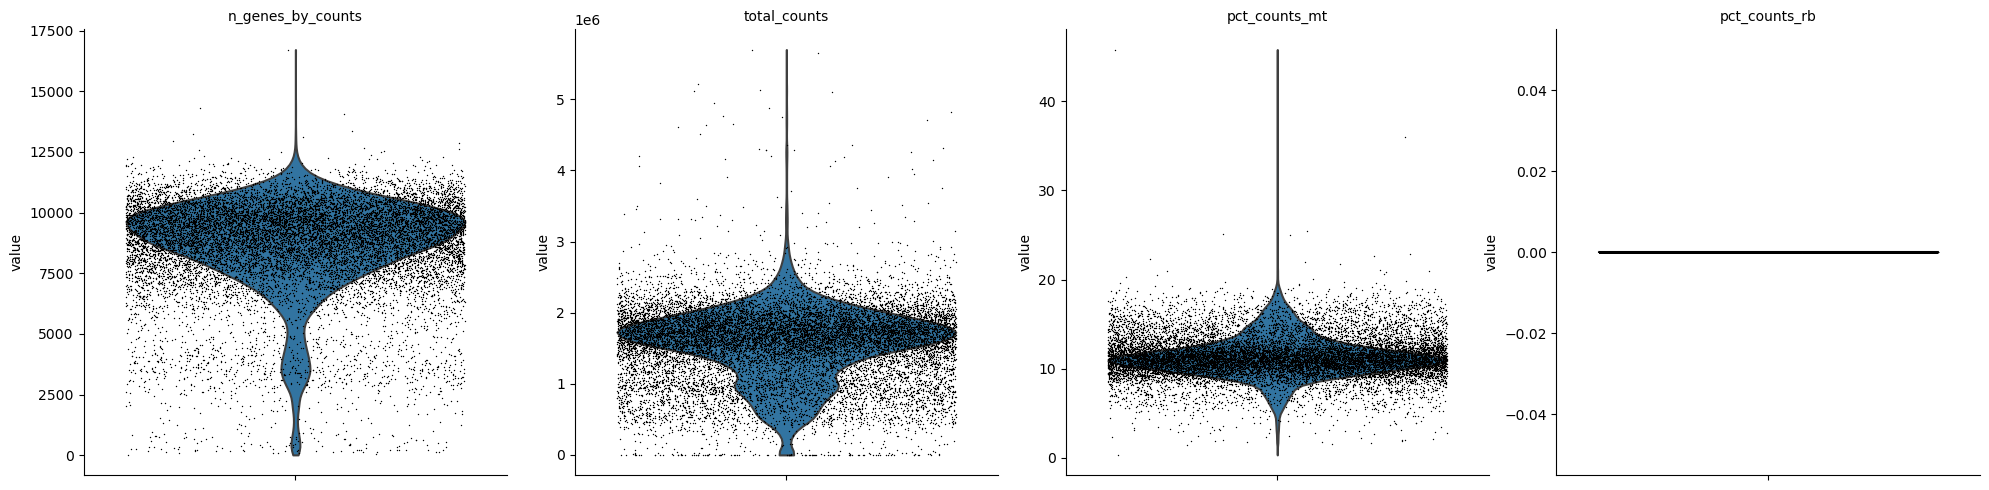

In [53]:
sc.pl.violin(adata_rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_rb'],
             jitter=0.4, multi_panel=True,save='_'+file_name+'_scRNA.svg')

In [54]:
adata_rna

AnnData object with n_obs × n_vars = 15413 × 38905
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rb'

In [55]:
adata = adata_rna[adata_rna.obs.n_genes_by_counts > 5000, :]
adata = adata[adata.obs.n_genes_by_counts < 12500, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [56]:
adata

View of AnnData object with n_obs × n_vars = 14425 × 38905
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rb'

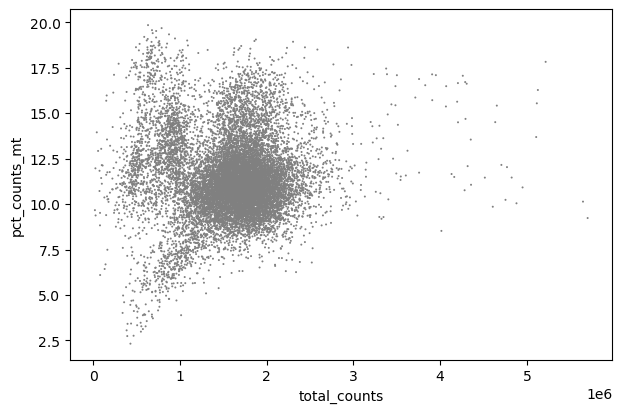

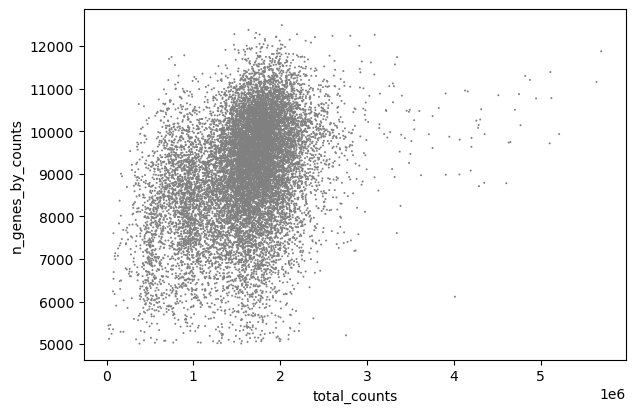

In [57]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',save='_'+file_name+'_scRNA_mt.svg')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',save='_'+file_name+'_scRNA_count.svg')

In [58]:
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

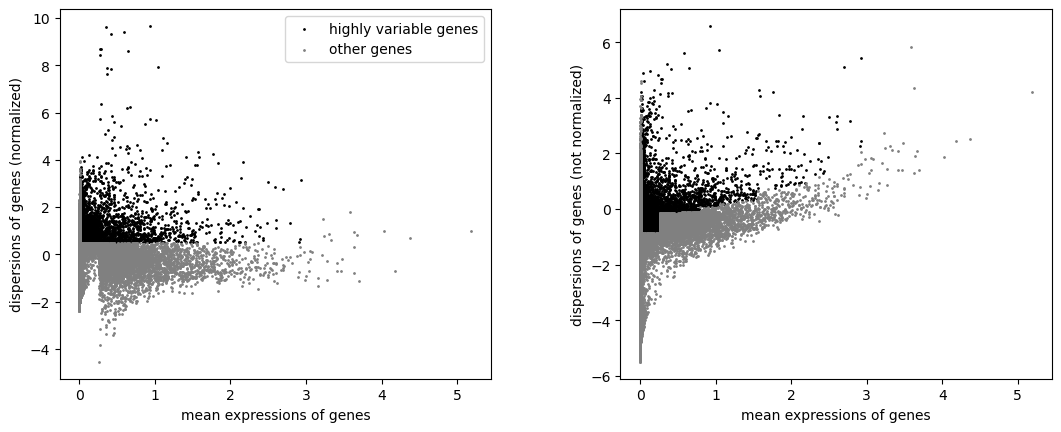

In [60]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata,save='_'+file_name+'_scRNA_hvg.svg')

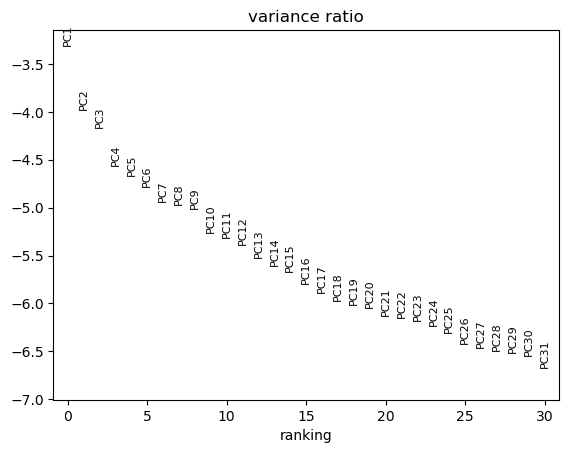

In [61]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [62]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

In [63]:
sc.tl.umap(adata)

In [64]:
sc.tl.leiden(adata,resolution=0.2)

In [6]:
adata = ad.read_h5ad(os.path.join(data_dir,'Allen_VISp.h5ad'))

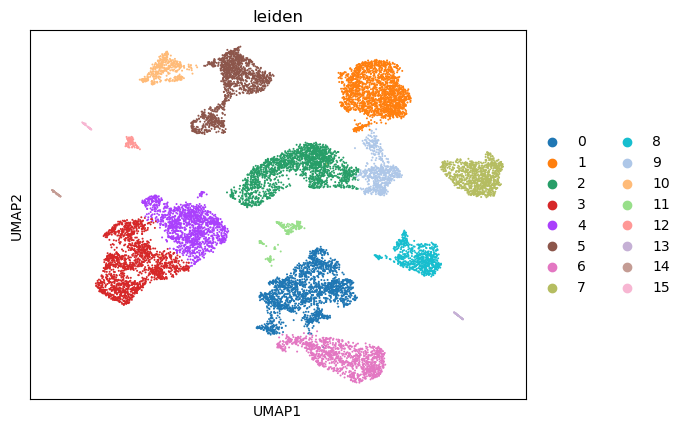

In [7]:
sc.pl.umap(adata, color='leiden')

In [72]:
sc_meta = sc_meta[sc_meta.sample_name.isin(adata.obs_names)]
sc_meta.index = sc_meta['sample_name']

In [59]:
adata.obs['cell_type'] = sc_meta.loc[adata.obs_names,'subclass']

NameError: name 'sc_meta' is not defined

In [70]:
adata.obs['SVZ_type'] =adata.obs['cell_type'] 
selected_type = ["Astro","VLMC","Endo","L5 IT","L6 IT","Macrophage","Meis2","Oligo"]#
adata_svz = adata[adata.obs.main_type.isin(selected_type)].copy()

In [71]:
adata_svz.obs.cell_type.cat.categories

Index(['Astro', 'Endo', 'L5 IT', 'L6 IT', 'Macrophage', 'Meis2', 'Oligo',
       'VLMC'],
      dtype='object')

In [72]:
new_cluster_names = ["Astrocyte_1","Endothelial_1","Interneuron_1","Interneuron_2",
                     "Microglia_1","Neuroblast_1","Oligodendrocyte_1","Choroid Plexus_1"]
adata_svz.rename_categories('SVZ_type', new_cluster_names)

In [75]:
adata_svz.obs['SVZ_type'] = adata_svz.obs['SVZ_type'].str[:-2]

In [62]:
selected_type = ["Astro","Endo","Macrophage","Oligo",
                   "High Intronic","L2/3 IT","L4", "L5 IT" ,"L5 PT","L6 CT","L6 IT","L6b","No Class","NP",
                   "Sst","Pvalb","Sncg","Vip"]#"Meis2","VLMC",

In [63]:
adata_use = adata[adata.obs.main_type.isin(selected_type)].copy()

In [64]:
adata_use.obs.cell_type.cat.categories

Index(['Astro', 'Endo', 'High Intronic', 'L2/3 IT', 'L4', 'L5 IT', 'L5 PT',
       'L6 CT', 'L6 IT', 'L6b', 'Macrophage', 'NP', 'No Class', 'Oligo',
       'Pvalb', 'Sncg', 'Sst', 'Vip'],
      dtype='object')

In [65]:
new_cluster_names = ["Astrocyte_1","Endothelial_1",
                     "Excitatory neuron_1","Excitatory neuron_2","Excitatory neuron_3","Excitatory neuron_4",
                     "Excitatory neuron_5","Excitatory neuron_6","Excitatory neuron_7","Excitatory neuron_8",
                     "Microglia_1","Excitatory neuron_9","Excitatory neuron_0",                    
                    "Oligodendrocyte_1",
                     "Interneuron_1","Interneuron_2","Interneuron_3","Interneuron_4"]
adata_use.rename_categories('Cortex_type', new_cluster_names)

In [66]:
adata_use.obs['Cortex_type'] = adata_use.obs['Cortex_type'].str[:-2]

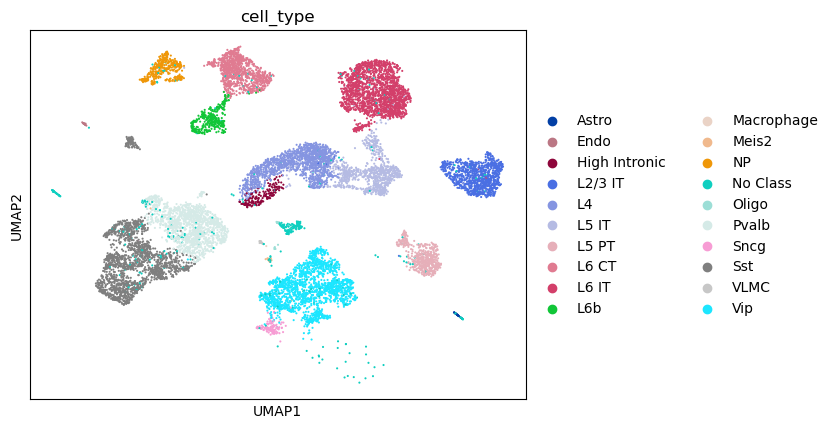

In [36]:
sc.pl.umap(adata_use, color='cell_type')

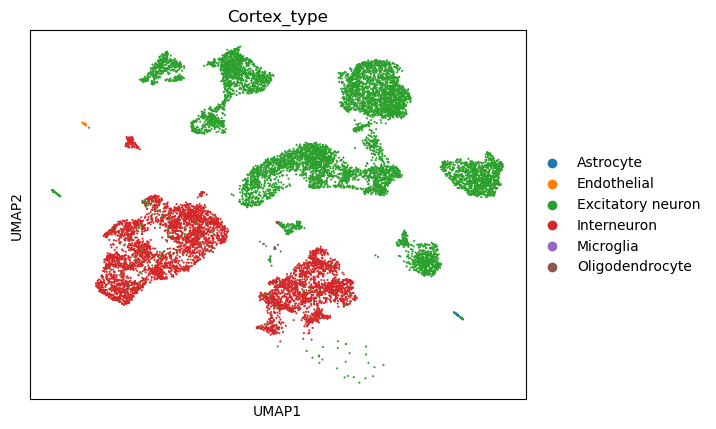

In [67]:
sc.pl.umap(adata_use, color='Cortex_type')

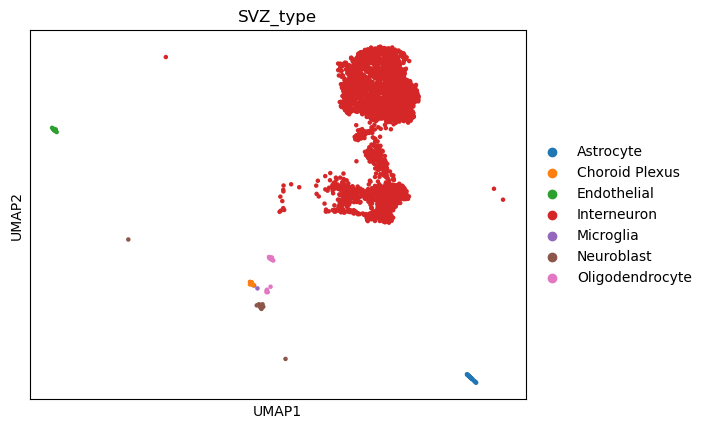

In [76]:
sc.pl.umap(adata_svz, color='SVZ_type')

In [39]:
adata.write(os.path.join(data_dir,'Allen_VISp.h5ad'))

In [68]:
adata_use.write(os.path.join(data_dir,'Allen_VISp_Cortex_type.h5ad'))

In [77]:
adata_svz.write(os.path.join(data_dir,'Allen_VISp_SVZ_type.h5ad'))

## data ##

In [11]:
data = pd.DataFrame(adata_use.X)

In [12]:
data.shape

(12973, 9922)

In [18]:
data.columns = adata_use.var_names
data.index = pd.Index(adata_use.obs_names)

In [15]:
adata_use.obs_names

Index(['F1S4_160108_001_A01', 'F1S4_160108_001_D01', 'F1S4_160108_001_F01',
       'F1S4_160108_001_G01', 'F1S4_160108_002_A01', 'F1S4_160108_002_C01',
       'F1S4_160108_002_D01', 'F1S4_160108_002_E01', 'F1S4_160108_002_F01',
       'F1S4_160108_002_G01',
       ...
       'FYS4_171004_103_G01', 'FYS4_171004_103_H01', 'FYS4_171004_104_A01',
       'FYS4_171004_104_B01', 'FYS4_171004_104_C01', 'FYS4_171004_104_D01',
       'FYS4_171004_104_E01', 'FYS4_171004_104_F01', 'FYS4_171004_104_G01',
       'FYS4_171004_104_H01'],
      dtype='object', length=12973)

In [20]:
data.to_csv(os.path.join(data_dir,'Allen_VISp_Cortex_exp.txt'),sep="\t")

In [43]:
os.path.join(data_dir,'Allen_VISp_Cortex_exp.txt')

'/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/SpaGE_Datasets/scRNAseq/Allen_VISp/Allen_VISp_Cortex_exp.txt'

In [81]:
data = pd.DataFrame(adata_svz.raw.X)
data.columns = adata.var_names
data.Index = adata_svz.obs_names
data.to_csv(os.path.join(data_dir,'Allen_VISp_SVZ_exp.txt'),sep="\t")

In [84]:
os.path.join(data_dir,'Allen_VISp_exp.txt')

'/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/SpaGE_Datasets/scRNAseq/Allen_VISp/Allen_VISp_exp.txt'

In [83]:
adata_use.obs.to_csv(os.path.join(data_dir,'Allen_VISp_Cortex_annotation.csv'))
adata_svz.obs.to_csv(os.path.join(data_dir,'Allen_VISp_SVZ_annotation.csv'))

In [87]:
adata_use

AnnData object with n_obs × n_vars = 12973 × 38905
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'leiden', 'cell_type', 'main_type', 'main_type_1', 'Cortex_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'main_type_colors', 'Cortex_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [86]:
adata_svz

AnnData object with n_obs × n_vars = 2870 × 38905
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb', 'leiden', 'cell_type', 'main_type', 'main_type_1', 'Cortex_type', 'SVZ_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rb', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap', 'main_type_colors', 'SVZ_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [95]:
ann = adata_use.obs[['Cortex_type']]

In [97]:
ann.columns = ['bio_celltype']

In [98]:
ann.to_csv("/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/Cortex_allField_77spot/sc_data/Allen_VISp_Cortex_annotation.tsv",
          sep="\t")

In [94]:
adata_svz.obs.SVZ_type.value_counts()

SVZ_type
Interneuron        2749
Astrocyte            30
Choroid Plexus       24
Oligodendrocyte      24
Neuroblast           21
Endothelial          19
Microglia             3
Name: count, dtype: int64

In [2]:
data_dir = '/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH+/'

In [4]:
adata_use = ad.read_h5ad(os.path.join(data_dir,'Allen_VISp_Cortex_type.h5ad'))

In [5]:
st_data = pd.read_table("/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/seqfish_SS_cortex/cortex_svz_expression.txt",
                       sep =" ")

In [6]:
gene = list(set(adata_use.var_names) & set(st_data.index.to_list()))

In [7]:
len(gene)

9922

In [8]:
adata_use = adata_use.raw

In [9]:
adata_use =adata_use[:,gene]

In [10]:
len(adata_use.var_names)

9922

In [20]:
ST_data_dir = '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/ST_data/'
sc_data_dir = '/data/lyx/hubs/SpaTD/stdgcn/stdGNN_data/sc_data/'

In [21]:
sc_data = pd.read_table(os.path.join(sc_data_dir,"sc_data.tsv"))
sc_data

,Unnamed: 0,1700022a21rik,1700025g04rik,4933401b06rik,5830417i10rik,9330102e08rik,9430018g01rik,9430083a17rik,Aanat,Aasdh,...,Tyrp1,Ubqlnl,Ptgdr,P2ry4,Prdm6,Pde6b,Zp1,Dlx4,Opn1sw,Pramef12
0,cell_845,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,cell_876,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cell_798,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,cell_864,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,cell_850,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,cell_628,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311,cell_896,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
312,cell_634,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
313,cell_550,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [64]:
sc_ann = pd.read_table(os.path.join(sc_data_dir,"sc_label.tsv"))
sc_ann

,Unnamed: 0,bio_celltype
0,cell_845,Choroid Plexus
1,cell_876,Choroid Plexus
2,cell_798,Neural Stem
3,cell_864,Choroid Plexus
4,cell_850,Choroid Plexus
...,...,...
310,cell_628,Neural Stem
311,cell_896,Choroid Plexus
312,cell_634,Neural Stem
313,cell_550,Neural Stem


In [6]:
ST_data = pd.read_table(os.path.join(ST_data_dir,"ST_data.tsv"))
ST_data

,Unnamed: 0,1700022a21rik,1700025g04rik,4933401b06rik,5830417i10rik,9330102e08rik,9430018g01rik,9430083a17rik,Aanat,Aasdh,...,Tyrp1,Ubqlnl,Ptgdr,P2ry4,Prdm6,Pde6b,Zp1,Dlx4,Opn1sw,Pramef12
0,spot338,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,spot343,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,spot354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,spot355,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,spot356,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,spot357,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,spot367,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,spot368,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0
8,spot369,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
9,spot370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0,2.0


In [36]:
ST_loc = pd.read_csv(os.path.join(ST_data_dir,"coordinates.csv"))
ST_loc

,Unnamed: 0,x,y
0,spot338,22,8
1,spot343,22,13
2,spot354,23,9
3,spot355,23,10
4,spot356,23,11
5,spot357,23,12
6,spot367,24,7
7,spot368,24,8
8,spot369,24,9
9,spot370,24,10


In [73]:
test_sc_data = pd.read_table(os.path.join(data_dir,"sc_data.tsv"))
test_sc_data

,Unnamed: 0,Tspan12,Tshz1,Fnbp1l,Adamts15,Cldn12,Rxfp1,2310042E22Rik,Sema3c,Jam2,...,Gm20826_loc1,Gm20826_loc2,Gm20877_loc2,Gm20877_loc1,Gm20865_loc4,Gm20738_loc4,Gm20738_loc6,Gm21943_loc1,Gm21943_loc3,Gm20738_loc3
0,1772071015_C02,0,3,3,0,1,0,0,11,1,...,0,0,0,0,0,0,0,0,0,0
1,1772071017_G12,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1772071017_A05,0,0,6,0,1,0,2,25,1,...,0,0,0,0,0,0,0,0,0,0
3,1772071014_B06,3,2,4,0,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1772067065_H06,0,2,1,0,0,0,0,10,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,1772063071_G10,0,0,0,0,0,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
1687,1772058148_C03,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,1772063061_D09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1689,1772063068_D01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [74]:
test_data = pd.read_table(os.path.join(data_dir,"sc_label.tsv"))
test_data

,Unnamed: 0,bio_celltype
0,1772071015_C02,iNeuron
1,1772071017_G12,iNeuron
2,1772071017_A05,iNeuron
3,1772071014_B06,iNeuron
4,1772067065_H06,iNeuron
...,...,...
1686,1772063071_G10,endo_mural
1687,1772058148_C03,endo_mural
1688,1772063061_D09,endo_mural
1689,1772063068_D01,endo_mural


In [66]:
test_data.index = test_sc_data["Unnamed: 0"]

In [68]:
test_data.columns = ['bio_celltype']

In [32]:
del test_data["cell_id"]

In [69]:
test_data

,bio_celltype
Unnamed: 0,
1772071015_C02,iNeuron
1772071017_G12,iNeuron
1772071017_A05,iNeuron
1772071014_B06,iNeuron
1772067065_H06,iNeuron
...,...
1772063071_G10,endo_mural
1772058148_C03,endo_mural
1772063061_D09,endo_mural


In [38]:
test_data["Rect_index"] = ['spot'+str(i) for i in test_data["Rect_index"]]

In [56]:
test_data.index = test_data.iloc[:,0]

In [58]:
test_data = test_data[["x","y"]]

In [70]:
test_data.to_csv(data_dir+"sc_label.tsv",sep="\t")

In [35]:
test_data = pd.read_table(os.path.join(data_dir,"sc_data.tsv"))
test_data

,Unnamed: 0,Tspan12,Tshz1,Fnbp1l,Adamts15,Cldn12,Rxfp1,2310042E22Rik,Sema3c,Jam2,...,Gm20826_loc1,Gm20826_loc2,Gm20877_loc2,Gm20877_loc1,Gm20865_loc4,Gm20738_loc4,Gm20738_loc6,Gm21943_loc1,Gm21943_loc3,Gm20738_loc3
0,1772071015_C02,0,3,3,0,1,0,0,11,1,...,0,0,0,0,0,0,0,0,0,0
1,1772071017_G12,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1772071017_A05,0,0,6,0,1,0,2,25,1,...,0,0,0,0,0,0,0,0,0,0
3,1772071014_B06,3,2,4,0,0,0,3,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1772067065_H06,0,2,1,0,0,0,0,10,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,1772063071_G10,0,0,0,0,0,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
1687,1772058148_C03,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1688,1772063061_D09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1689,1772063068_D01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ST ##

In [97]:
st_data = pd.read_table("./cortex_svz_expression.txt",sep=" ")
# st_data.transpose().to_csv("./cortex_svz_expression_transpose.txt",sep="\t")

In [98]:
st_data.shape

(10000, 913)

In [4]:
st_data = sc.read_csv("./cortex_svz_expression_transpose.txt",delimiter="\t")

In [66]:
ann =  pd.read_csv("./cortex_annotation.csv",index_col=0)

In [29]:
# ann.columns = ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.6',
#        'original.label', 'scMAGIC', 'Field.of.View', 'Region', 'X', 'Y',
#        'Dataset2_ann']

In [11]:
cortex_st_data = st_data[ann.index,:].copy()

In [ ]:
ann.loc[ann.Cluster=='Excitatory neuron', 'Cluster'] = 'Excitatory_neuron'

In [73]:
cortex_st_data.obs = ann.copy()

In [74]:
ann.to_csv("./cortex_annotation.csv")

In [99]:
data = pd.DataFrame(cortex_st_data.X)
data.columns = cortex_st_data.var_names
data.index = pd.Index(cortex_st_data.obs_names)
data.to_csv('/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/ST_Cortex_exp_transpose.txt',sep="\t")
data.transpose().to_csv('/data/lyx/hubs/SpaTD/stdgcn/benchmark_data/seqFISH_plus/ST_Cortex_exp.txt',sep="\t")

In [16]:
cortex_sc_data =ad.read_h5ad("../Allen_VISp/Allen_VISp.h5ad")

In [19]:
len(set(cortex_sc_data.obs_names) &set(nc_sc_data.columns))

0

In [128]:
cortex_sc_data.obs.cell_type.value_counts()

L6 IT             1871
Sst               1739
Vip               1722
L4                1400
Pvalb             1333
Lamp5             1121
L2/3 IT            982
L6 CT              960
L5 IT              878
L5 PT              543
No Class           446
NP                 362
L6b                357
High Intronic      179
Batch Grouping     130
Sncg               125
Low Quality         66
Doublet             51
Astro               30
Serpinf1            26
Oligo               24
VLMC                24
Meis2               21
Endo                19
SMC                 10
Macrophage           3
CR                   3
Name: cell_type, dtype: int64

In [132]:
cortex_sc_data.obs.main_type_1.value_counts()

L6 IT             1871
Sst               1739
Vip               1722
L4                1400
Pvalb             1333
Lamp5             1121
L2/3 IT            982
L6 CT              960
L5 IT              878
L5 PT              543
No Class           446
NP                 362
L6b                357
High Intronic      179
Batch Grouping     130
Sncg               125
Low Quality         66
Doublet             51
Astro               30
Serpinf1            26
Oligo               24
VLMC                24
Meis2               21
Endo                19
SMC                 10
Macrophage           3
CR                   3
Name: main_type_1, dtype: int64

In [119]:
nc_sc_data = pd.read_table("../Dataset3_seqFISHplus_sometasensory/stdGCN/raw_somatosensory_sc_exp.txt",index_col=0)

In [126]:
nc_sc_data.transpose().to_csv("../Dataset3_seqFISHplus_sometasensory/Cortex_allField_77spot/sc_data/sc_data.tsv" ,sep="\t")

In [82]:
nc_sc_ann = pd.read_table("../Dataset3_seqFISHplus_sometasensory/data4STRIDE/sc_celltype.txt",header=None)

In [120]:
common_gene = list(set(nc_sc_data.index)&set(cortex_st_data.var_names))

In [121]:
nc_sc_data = nc_sc_data.loc[common_gene,:]
nc_sc_data.index = nc_sc_data.index.to_list()

In [84]:
# nc_sc_ann['ann'] = ''

In [70]:
# nc_sc_ann['ann'] = nc_sc_ann[1].map({'Olig':'Oligodendrocyte',
#                                      'eNeuron':'Excitatory_neuron',
#                                      'endo_mural':'Endothelial',
#                                      'iNeuron':'Interneuron',
#                                      'astrocytes':'Astrocyte',
#                                     'microglia':'Microglia'},
#                              na_action=None)
#nc_sc_ann = nc_sc_ann[[0, 'ann']]

In [72]:
#nc_sc_ann.to_csv("../Dataset3_seqFISHplus_sometasensory/data4STRIDE/sc_celltype.txt",header=None,index=None,sep="\t")

In [85]:
# nc_sc_ann.columns = ['','bio_celltype']
# nc_sc_ann.index = nc_sc_ann['']
# nc_sc_ann = nc_sc_ann[['bio_celltype']]

In [87]:
# nc_sc_ann.to_csv("../Dataset3_seqFISHplus_sometasensory/TopicGNN/sc_data/sc_label.tsv",sep="\t")

In [104]:
stdGCN_sc_ann = pd.read_table("../10000genes/sc_data/sc_label.tsv")

In [106]:
stdGCN_sc_data = pd.read_table("../10000genes/sc_data/sc_data.tsv")

In [37]:
nc_sc_data.shape

(19972, 1690)

In [105]:
stdGCN_sc_ann

,Unnamed: 0,bio_celltype
0,1772071015_C02,iNeuron
1,1772071017_G12,iNeuron
2,1772071017_A05,iNeuron
3,1772071014_B06,iNeuron
4,1772067065_H06,iNeuron
...,...,...
1686,1772063071_G10,endo_mural
1687,1772058148_C03,endo_mural
1688,1772063061_D09,endo_mural
1689,1772063068_D01,endo_mural


In [21]:
cortex_sc_data.obs_names

Index(['F1S4_160108_001_A01', 'F1S4_160108_001_B01', 'F1S4_160108_001_C01',
       'F1S4_160108_001_D01', 'F1S4_160108_001_E01', 'F1S4_160108_001_F01',
       'F1S4_160108_001_G01', 'F1S4_160108_001_H01', 'F1S4_160108_002_A01',
       'F1S4_160108_002_B01',
       ...
       'FYS4_171004_103_G01', 'FYS4_171004_103_H01', 'FYS4_171004_104_A01',
       'FYS4_171004_104_B01', 'FYS4_171004_104_C01', 'FYS4_171004_104_D01',
       'FYS4_171004_104_E01', 'FYS4_171004_104_F01', 'FYS4_171004_104_G01',
       'FYS4_171004_104_H01'],
      dtype='object', length=14425)